# Orbit-like model in PyMC

**References**
- [Bayesian Time Varying Coefficient Model with Applications to Marketing Mix Modeling](https://arxiv.org/abs/2106.03322)
- [KTR Regression part 2](https://orbit-ml.readthedocs.io/en/latest/tutorials/ktr2.html)
- [uber/orbit](https://github.com/uber/orbit)
- [Original Paper](https://arxiv.org/abs/2106.03322)

**Dr. Juan Camilo Orduz's Blogs**
- [Media Effect Estimation with Orbit's KTR Model](https://juanitorduz.github.io/orbit_mmm/)
- [Media Effect Estimation with PyMC: Adstock, Saturation & Diminishing Returns](https://juanitorduz.github.io/pymc_mmm/)

In [1]:
import arviz as az
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pymc as pm
import pytensor.tensor as pt
from sklearn.preprocessing import MaxAbsScaler

### Kernel Generation
Based on https://github.com/uber/orbit/blob/dev/orbit/utils/kernels.py

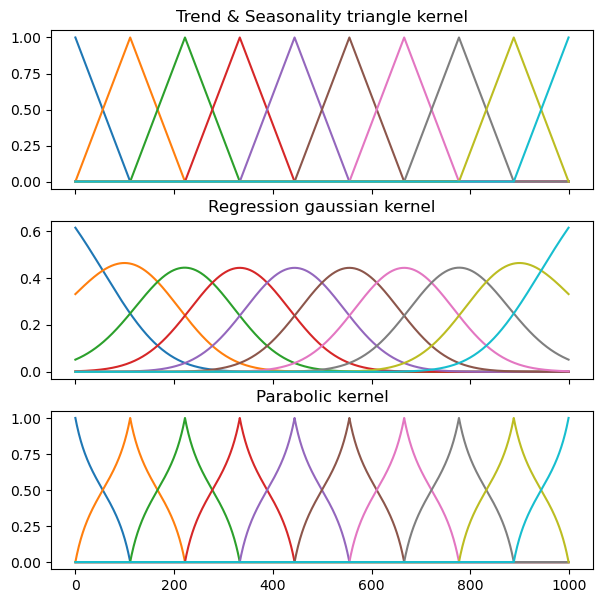

In [2]:
def gaussian_kernel(t, t_refs, rho: float = 0.1, alpha: float = 1, point_to_flatten: float = 1):
    ker = np.where(
        (t <= point_to_flatten).reshape(-1, 1),
        (alpha**2) * np.exp(-1 * np.power(t.reshape(-1, 1) - t_refs.reshape(1, -1), 2)/(2 * rho**2 )),
        (alpha**2) * np.exp(-1 * np.power(np.array([point_to_flatten] * t.shape[0]).reshape(-1, 1) - t_refs.reshape(1, -1), 2)/(2 * rho**2 ))
    )
    return ker / np.sum(ker, axis=1, keepdims=True)

def triangle_kernel(t, t_refs):
    ker = np.zeros((t.shape[0], t_refs.shape[0]))
    ker[t < t_refs[0], 0] = 1
    for idx in range(t_refs.shape[0] - 1):
        valid_idxes = (t >= t_refs[idx]) & (t < t_refs[idx + 1])
        norm = t_refs[idx + 1] - t_refs[idx]
        ker[valid_idxes, idx] = np.abs(t[valid_idxes] - t_refs[idx + 1])/norm
        ker[valid_idxes, idx + 1] = np.abs(t[valid_idxes] - t_refs[idx])/norm
    ker[t >= t_refs[-1], -1] = 1
    return ker / np.sum(ker, axis=1, keepdims=True)

def parabolic_kernel(t, t_refs):
    ker = np.zeros((t.shape[0], t_refs.shape[0]))
    ker[t < t_refs[0], 0] = 1
    for idx in range(t_refs.shape[0] - 1):
        valid_idxes = (t >= t_refs[idx]) & (t < t_refs[idx + 1])
        norm = t_refs[idx + 1] - t_refs[idx]
        ker[valid_idxes, idx] = 0.75 * (1 - ((t[valid_idxes] - t_refs[idx])/norm)**2)
        ker[valid_idxes, idx + 1] = 0.75 *(1 - ((t[valid_idxes] - t_refs[idx + 1])/norm)**2)
    ker[t >= t_refs[-1], -1] = 1
    return ker / np.sum(ker, axis=1, keepdims=True)

n_steps = 1_000
n_knots = 9

t_norm = np.linspace(0, 1, n_steps)
t_norm_refs = np.linspace(t_norm.min(), t_norm.max(), n_knots + 1)

g_ker = gaussian_kernel(t_norm, t_norm_refs)
t_ker = triangle_kernel(t_norm, t_norm_refs)
p_ker = parabolic_kernel(t_norm, t_norm_refs)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(7, 7))
for i in range(g_ker.shape[1]):
    ax1.plot(t_ker[:, i])
for i in range(t_ker.shape[1]):
    ax2.plot(g_ker[:, i])
for i in range(p_ker.shape[1]):
    ax3.plot(p_ker[:, i])
ax1.set_title("Trend & Seasonality triangle kernel")
ax2.set_title("Regression gaussian kernel")
ax3.set_title("Parabolic kernel")
plt.show()

## Data Preparation

### Generate Synthetic Data

In [3]:
def sim_data_rw(n, RS, p=3):
    """ coefficients curve are random walk like
    """
    np.random.seed(RS)

    # initializing coefficients at zeros, simulate all coefficient values
    lev = np.cumsum(np.concatenate((np.array([5.0]), np.random.normal(0, 0.01, n-1))))
    beta = np.concatenate(
        [np.random.uniform(0.05, 0.12, size=(1,p)),
         np.random.normal(0.0, 0.01, size=(n-1,p))],
            axis=0)
    beta = np.cumsum(beta, 0)

    # simulate regressors
    covariates = np.random.normal(0, 10, (n, p))

    # observation with noise
    y = lev + (covariates * beta).sum(-1) + 0.3 * np.random.normal(0, 1, n)

    regressor_col = ['x{}'.format(pp) for pp in range(1, p+1)]
    data = pd.DataFrame(covariates, columns=regressor_col)
    beta_col = ['beta{}'.format(pp) for pp in range(1, p+1)]
    beta_data = pd.DataFrame(beta, columns=beta_col)
    data = pd.concat([data, beta_data], axis=1)

    data['y'] = y
    data['date'] = pd.date_range(start='1/1/2018', periods=len(y))

    return data

rw_data = sim_data_rw(n=300, RS=2021, p=3)
rw_data.head(10)

,x1,x2,x3,beta1,beta2,beta3,y,date
0,14.029705,-2.554694,4.937591,0.072883,0.062513,0.096618,6.117037,2018-01-01
1,6.239695,0.570144,-6.997000,0.066693,0.054400,0.104760,5.357839,2018-01-02
2,9.918098,-6.687280,-3.689570,0.067551,0.044866,0.116235,4.825672,2018-01-03
3,-1.177239,8.880898,-16.027647,0.058488,0.043045,0.122937,3.636049,2018-01-04
4,11.610645,1.953064,0.199013,0.066043,0.032811,0.118969,5.859127,2018-01-05
5,7.319292,3.360167,-6.099329,0.078252,0.034478,0.108355,5.088045,2018-01-06
6,0.534049,8.804120,-1.836921,0.074667,0.018469,0.105070,4.593033,2018-01-07
7,-16.039469,0.275616,-22.009645,0.068869,0.008649,0.107494,1.266506,2018-01-08
8,-17.722379,2.651947,0.225712,0.070071,0.010075,0.104321,4.106286,2018-01-09
9,-7.398947,-7.631622,3.255354,0.077153,0.014981,0.093563,4.307877,2018-01-10


In [4]:
def sim_data_seasonal(n, RS):
    """ coefficients curve are sine-cosine like
    """
    np.random.seed(RS)
    # make the time varing coefs
    tau = np.arange(1, n+1)/n
    data = pd.DataFrame({
        'tau': tau,
        'date': pd.date_range(start='1/1/2018', periods=n),
        'beta1': 2 * tau,
        'beta2': 1.01 + np.sin(2*np.pi*tau),
        'beta3': 1.01 + np.sin(4*np.pi*(tau-1/8)),
        'x1': np.random.normal(0, 10, size=n),
        'x2': np.random.normal(0, 10, size=n),
        'x3': np.random.normal(0, 10, size=n),
        'trend': np.cumsum(np.concatenate((np.array([1]), np.random.normal(0, 0.1, n-1)))),
        'error': np.random.normal(0, 1, size=n) #stats.t.rvs(30, size=n),#
    })

    data['y'] = data.x1 * data.beta1 + data.x2 * data.beta2 + data.x3 * data.beta3 + data.error
    return data

sc_data = sim_data_seasonal(n=80, RS=2021)
sc_data.head(10)

,tau,date,beta1,beta2,beta3,x1,x2,x3,trend,error,y
0,0.0125,2018-01-01,0.025,1.088459,0.022312,14.886091,1.565561,-14.693990,1.000000,-0.734759,1.013594
1,0.0250,2018-01-02,0.050,1.166434,0.058943,6.760109,-0.568613,4.931575,1.077461,-0.970072,-1.004632
2,0.0375,2018-01-03,0.075,1.243445,0.118993,-4.184514,-5.382336,-13.905780,1.192014,-0.138909,-8.800086
3,0.0500,2018-01-04,0.100,1.319017,0.200983,-8.065208,9.013873,-0.752441,1.228833,0.665502,11.597206
4,0.0625,2018-01-05,0.125,1.392683,0.302893,5.558758,2.249442,-2.535098,1.313407,-1.582592,1.477150
5,0.0750,2018-01-06,0.150,1.463990,0.422215,-7.055043,12.777882,14.258412,1.259112,-0.980490,22.688063
6,0.0875,2018-01-07,0.175,1.532499,0.556010,11.308583,6.292686,7.820977,1.234839,-0.537506,15.433566
7,0.1000,2018-01-08,0.200,1.597785,0.700983,6.450018,3.618912,16.280980,1.132366,-1.328576,17.156362
8,0.1125,2018-01-09,0.225,1.659448,0.853566,1.064137,36.387259,8.804575,1.028345,0.878594,69.016072
9,0.1250,2018-01-10,0.250,1.717107,1.010000,4.221548,-12.012208,8.431756,1.006486,-0.220554,-11.275337


### Process Data + Generate Features

In [5]:
# Hyper parameters
n_knots = 10
n_order = 3

data_df = rw_data
# data_df = sc_data

date = data_df.date.to_numpy()
t = np.array(data_df.date.index)
t = (t - t.min())/(t.max() - t.min())
y = data_df["y"].to_numpy().reshape(-1, 1)
y_scaler = MaxAbsScaler().fit(y)
y_scaled = y_scaler.transform(y).reshape(-1)
x = data_df[["x1", "x2", "x3"]].to_numpy()
x_scaler = MaxAbsScaler().fit(x)
x_scaled = x_scaler.transform(x)

t_refs = np.linspace(t.min(), t.max(), n_knots + 1)
periods = np.array(data_df.date.dt.day_of_year) / 365.25

trend_ker = triangle_kernel(t, t_refs)
reg_ker = gaussian_kernel(t, t_refs)
fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)

## Modeling

Sampling: [b_fourier, b_fourier_sigma, b_regs, b_trend, b_trend_sigma, likelihood, nu, pool_mu, pool_sigma, reg_mu, reg_sigma, sigma]


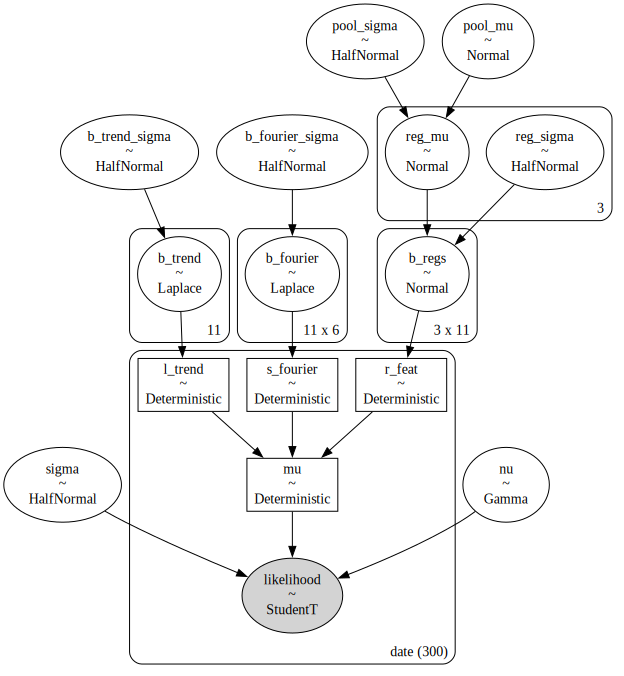

/Users/thipok.tham/miniconda3/envs/python311/lib/python3.11/site-packages/pymc/sampling/mcmc.py:243: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.443576
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:19.236547
Transforming variables...
Transformation time =  0:00:00.289686
Computing Log Likelihood...


Sampling: [likelihood]


Log Likelihood time =  0:00:00.450012


In [6]:
is_only_positive = False

coords = {
    "date": date,
    "fourier_mode": np.arange(2 * n_order)
}
with pm.Model(coords=coords) as model:
    # Trend Priors
    b_trend_sigma = pm.HalfNormal("b_trend_sigma", sigma=1)
    b_trend = pt.cumsum(pm.Laplace("b_trend", mu=0, b=b_trend_sigma, shape=(n_knots + 1, )))
    
    # Fourier Priors
    b_fourier_sigma = pm.HalfNormal("b_fourier_sigma", sigma=1) 
    b_fourier = pt.cumsum(pm.Laplace("b_fourier", mu=0, b=b_fourier_sigma, shape=(n_knots + 1, 2 * n_order)), axis=0)
    
    # Regression Priors
    pool_mu = pm.Normal("pool_mu", mu=0, sigma=1)
    pool_sigma = pm.HalfNormal("pool_sigma", sigma=1) 
    reg_mu = pm.Normal("reg_mu", mu=pool_mu, sigma=pool_sigma, shape=(x_scaled.shape[1], ))
    reg_sigma = pm.HalfNormal("reg_sigma", sigma=0.25, shape=(x_scaled.shape[1], ))
    if is_only_positive:
        b_regs = pt.abs(
            pm.Normal(
                "b_regs",
                mu=pt.abs(reg_mu.reshape((x_scaled.shape[1], 1))),
                sigma=reg_sigma.reshape((x_scaled.shape[1], 1)),
                shape=(x_scaled.shape[1], len(t_refs), )
            ).T
        )
    else:
        b_regs = pm.Normal(
            "b_regs",
            mu=reg_mu.reshape((x_scaled.shape[1], 1)),
            sigma=reg_sigma.reshape((x_scaled.shape[1], 1)),
            shape=(x_scaled.shape[1], len(t_refs), )
        ).T
    
    # Calculation
    l_trend = pm.Deterministic("l_trend", var=(pm.math.dot(trend_ker, b_trend)), dims="date")
    s_fourier = pm.Deterministic("s_fourier", var=((fourier_features.to_numpy() * pm.math.dot(trend_ker, b_fourier))).sum(axis=1), dims="date")
    r_feat = pm.Deterministic("r_feat", var=((x_scaled * pm.math.dot(reg_ker, b_regs))).sum(axis=1), dims="date")
    
    nu = pm.Gamma(name="nu", alpha=10, beta=1)
    sigma = pm.HalfNormal(name="sigma", sigma=0.5)
    mu = pm.Deterministic("mu", var=(l_trend + s_fourier + r_feat), dims="date")
    
     # --- likelihood ---
    pm.StudentT(name="likelihood", nu=nu, mu=mu, sigma=sigma, observed=y_scaled, dims="date")
    
    model_prior_predictive = pm.sample_prior_predictive()

display(pm.model_to_graphviz(model=model))

with model:
    model_trace = pm.sample(
        nuts_sampler="numpyro",
        # draws=30_000,
        # tune=30_000,
        draws=1_000,
        tune=1_000,
        chains=4,
        idata_kwargs={"log_likelihood": True},
    )
    model_posterior_predictive = pm.sample_posterior_predictive(
        trace=model_trace
    )

## Diagnostic plots

  0%|          | 0/10 [00:00<?, ?it/s]

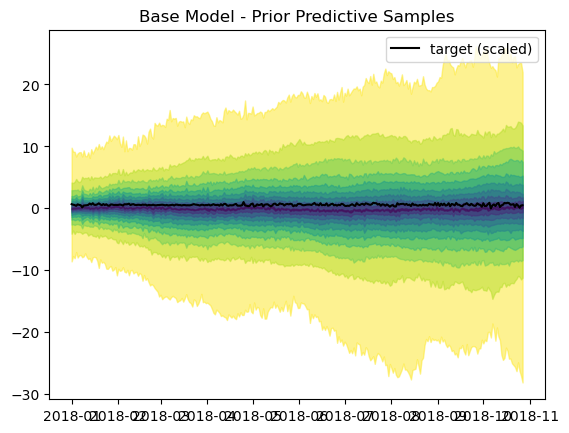

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_trend_sigma,0.096,0.038,0.044,0.167,0.002,0.002,298.0,1693.0,1.02
b_fourier_sigma,0.007,0.006,0.000,0.019,0.002,0.001,9.0,23.0,1.38
pool_mu,-0.038,0.249,-0.572,0.428,0.007,0.005,1081.0,970.0,1.01
pool_sigma,0.364,0.303,0.004,0.929,0.011,0.007,503.0,656.0,1.01
reg_mu[0],-0.185,0.165,-0.499,0.118,0.005,0.003,1263.0,1494.0,1.00
reg_mu[1],-0.038,0.120,-0.266,0.187,0.003,0.002,1829.0,1225.0,1.00
reg_mu[2],0.120,0.143,-0.141,0.385,0.005,0.003,950.0,1616.0,1.00
reg_sigma[0],0.554,0.111,0.347,0.753,0.003,0.002,1063.0,1504.0,1.01
reg_sigma[1],0.422,0.101,0.240,0.602,0.003,0.002,922.0,2262.0,1.01
reg_sigma[2],0.471,0.106,0.276,0.663,0.003,0.002,1041.0,2069.0,1.00


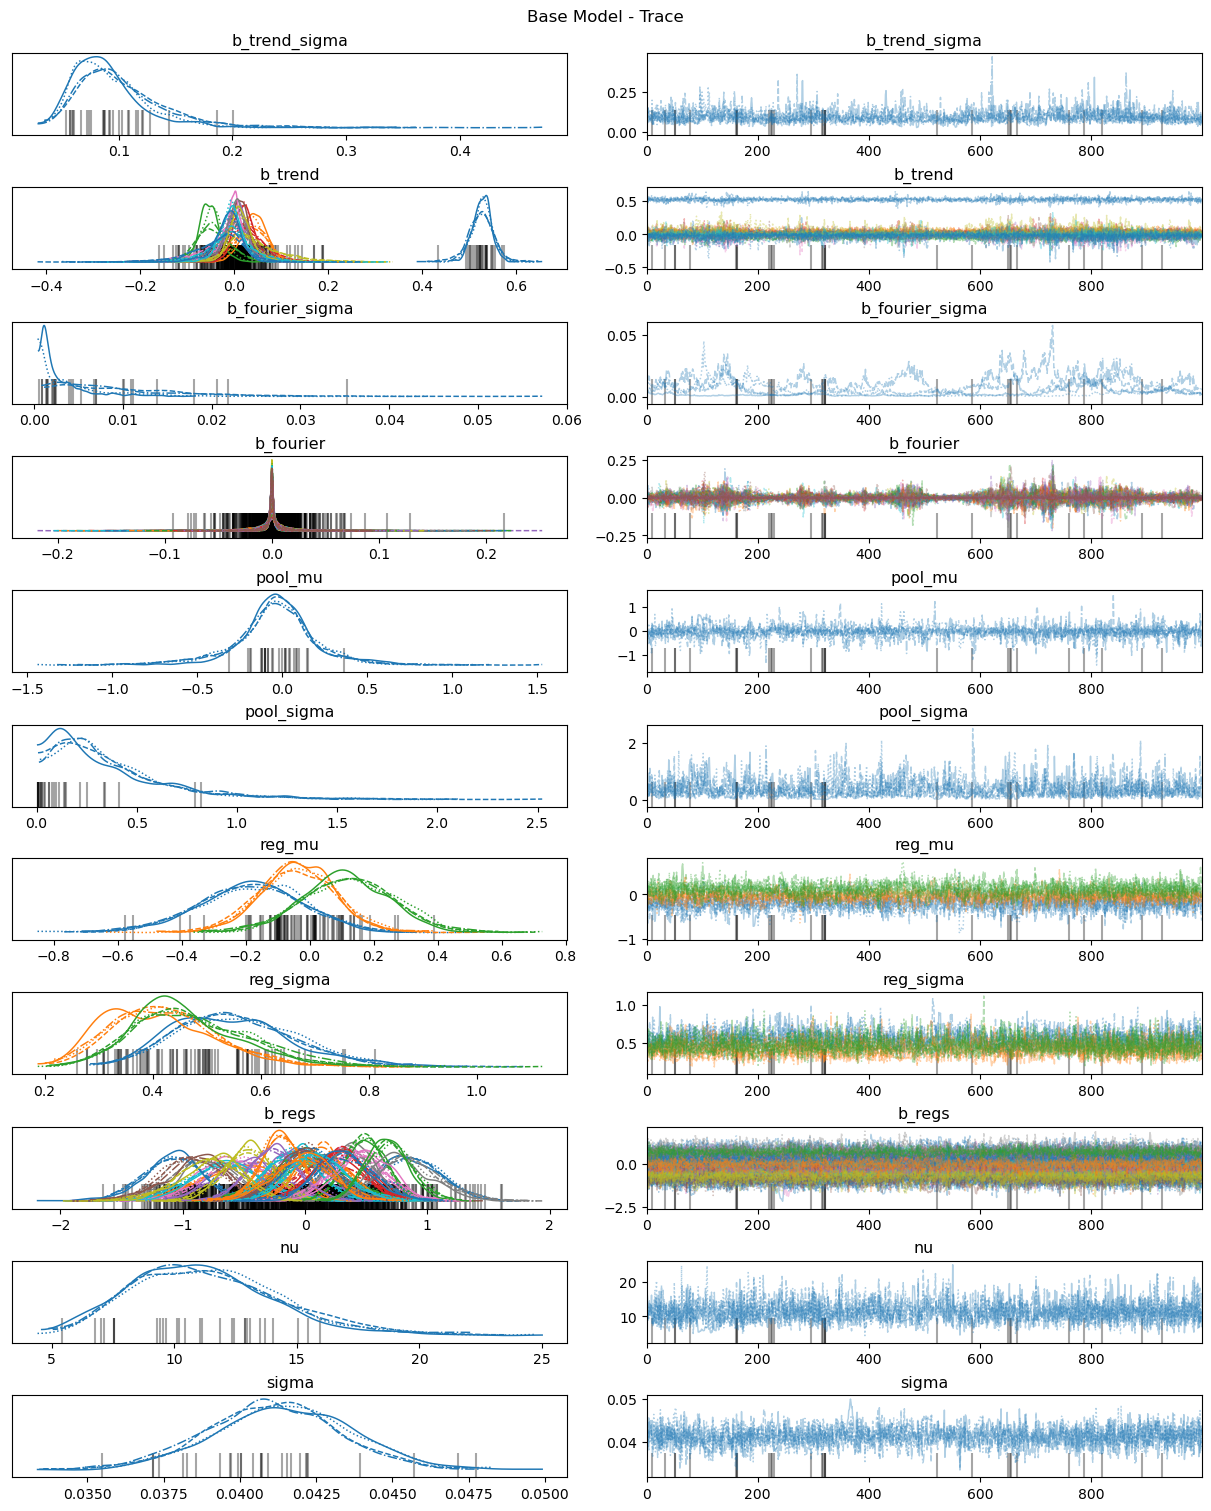

In [7]:
# useful way to color the distribution
palette = "viridis_r"
cmap = plt.get_cmap(palette)
percs = np.linspace(51, 99, 100)
percs = np.linspace(51, 99, 10)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))

fig, ax = plt.subplots()

for i, p in tqdm(enumerate(percs[::-1]), total=len(percs)):
    upper = np.percentile(model_prior_predictive.prior_predictive["likelihood"], p, axis=1)
    lower = np.percentile(
        model_prior_predictive.prior_predictive["likelihood"], 100 - p, axis=1
    )
    color_val = colors[i]
    ax.fill_between(
        x=date,
        y1=upper.flatten(),
        y2=lower.flatten(),
        color=cmap(color_val),
        alpha=0.5,
    )

sns.lineplot(x=date, y=y_scaled, color="black", label="target (scaled)", ax=ax)
ax.legend()
ax.set(title="Base Model - Prior Predictive Samples");
plt.show()

display(az.summary(
    data=model_trace,
    var_names=[
        "b_trend_sigma", "b_fourier_sigma",
        "pool_mu", "pool_sigma",
        "reg_mu", "reg_sigma",
        "nu", "sigma"
    ],
))

axes = az.plot_trace(
    data=model_trace,
    var_names=[
        "b_trend_sigma", "b_trend",
        "b_fourier_sigma", "b_fourier",
        "pool_mu", "pool_sigma",
        "reg_mu", "reg_sigma",
        "b_regs",
        "nu", "sigma"
    ],
    compact=True,
    backend_kwargs={
        "figsize": (12, 15),
        "layout": "constrained"
    },
)
fig = axes[0][0].get_figure()
fig.suptitle("Base Model - Trace");
plt.show()

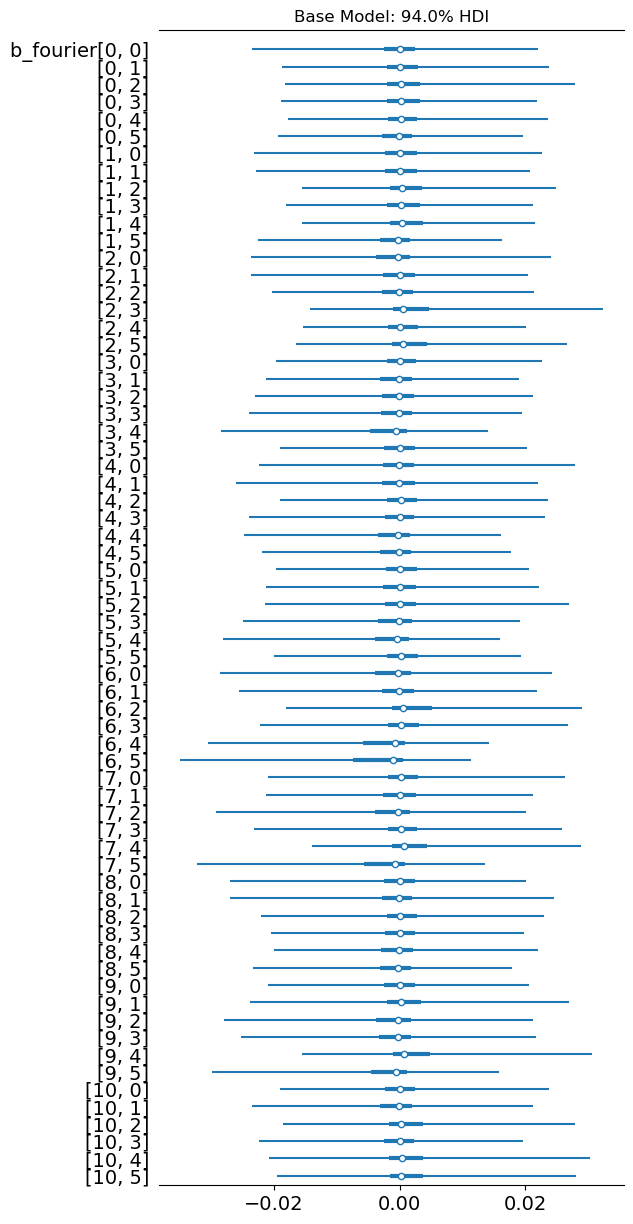

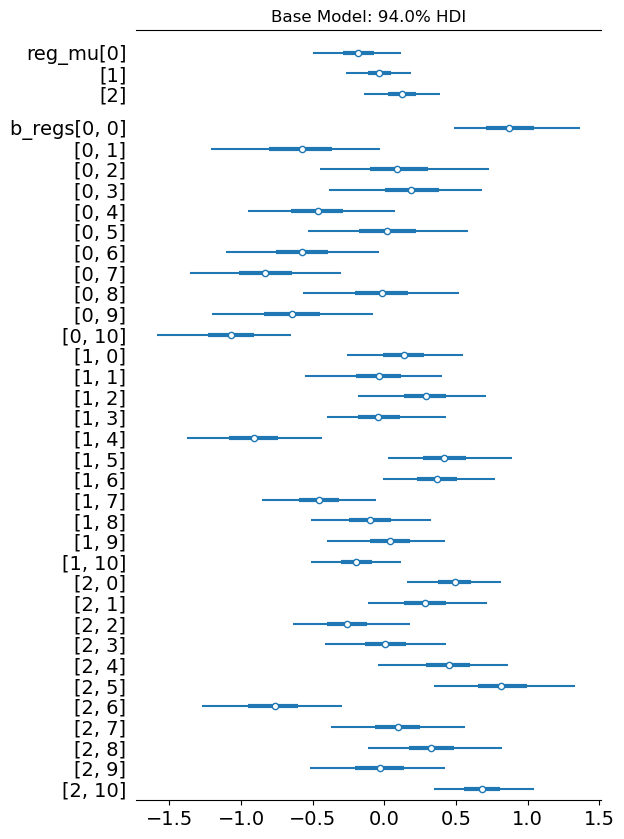

In [8]:
fig, ax = plt.subplots(figsize=(6, 15))
az.plot_forest(
    data=model_trace,
    var_names=["b_fourier"],
    combined=True,
    ax=ax
)
ax.set(
    title="Base Model: 94.0% HDI",
);
plt.show()

fig, ax = plt.subplots(figsize=(6, 10))
az.plot_forest(
    data=model_trace,
    var_names=["reg_mu", "b_regs"],
    combined=True,
    ax=ax
)
ax.set(
    title="Base Model: 94.0% HDI",
);
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

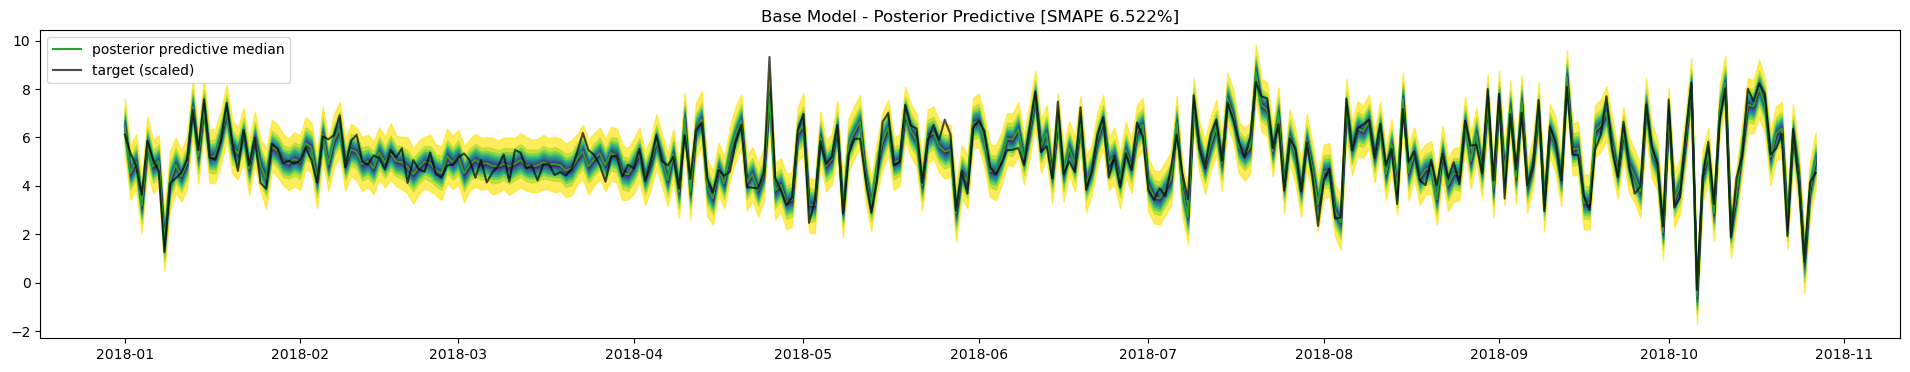

,0,1
0,1.000000,0.957086
1,0.957086,1.000000


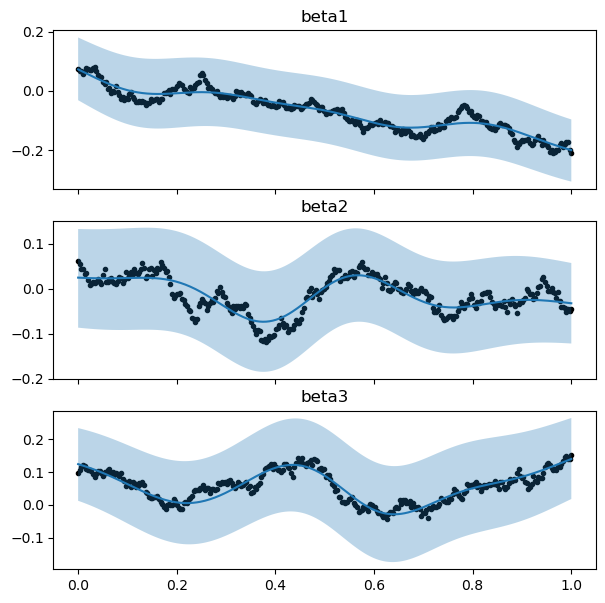

In [9]:
def calculate_smape(actual, predicted) -> float:
    if not all([isinstance(actual, np.ndarray), 
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual),
        np.array(predicted)
    return (
        100 * np.mean(
            np.abs(predicted - actual) / 
            ((np.abs(predicted) + np.abs(actual))/2)
        )
    )

posterior_predictive_likelihood = az.extract(
    data=model_posterior_predictive,
    group="posterior_predictive",
    var_names="likelihood",
)

posterior_predictive_likelihood_inv = y_scaler.inverse_transform(
    X=posterior_predictive_likelihood
)

fig, ax = plt.subplots(figsize=(24, 4))

for i, p in tqdm(enumerate(percs[::-1]), total=len(percs[::-1])):
    upper = np.percentile(posterior_predictive_likelihood_inv, p, axis=1)
    lower = np.percentile(posterior_predictive_likelihood_inv, 100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(
        x=date,
        y1=upper,
        y2=lower,
        color=cmap(color_val),
        alpha=0.75,
    )

sns.lineplot(
    x=date,
    y=np.median(posterior_predictive_likelihood_inv, axis=1),
    color="C2",
    label="posterior predictive median",
    ax=ax,
)
sns.lineplot(
    x=date,
    y=y.reshape(-1),
    color="black",
    label="target (scaled)",
    ax=ax,
    alpha=0.7
)
ax.legend(loc="upper left")
ax.set(title=f"Base Model - Posterior Predictive [SMAPE {calculate_smape(y.reshape(-1), np.median(posterior_predictive_likelihood_inv, axis=1)):.3f}%]");
plt.show()

display(pd.DataFrame([
    np.median(posterior_predictive_likelihood_inv, axis=1),
    y.reshape(-1)
]).T.corr())

b_regs_est = np.mean(model_trace.posterior.b_regs.to_numpy().reshape(-1, x.shape[-1], len(t_refs)), axis=0)
b_regs_min, b_regs_max = np.quantile(
    model_trace.posterior.b_regs.to_numpy().reshape(-1, x.shape[-1], len(t_refs)),
    [0.05, 0.95], axis=0
)

# Need to rescale if the x-y inputs are rescaled
rescale = 1/(x_scaler.scale_/y_scaler.scale_[0]).reshape(-1, 1)
b_coeff_min = rescale * (reg_ker @ b_regs_min.T).T
b_coeff_est = rescale * (reg_ker @ b_regs_est.T).T
b_coeff_max = rescale * (reg_ker @ b_regs_max.T).T

fig, axes = plt.subplots(3, 1, sharex=True, figsize=(7, 7))

for i in range(x.shape[-1]):
    axes[i].scatter(t, data_df[f"beta{i + 1}"], marker=".", color="k")
    axes[i].fill_between(t, b_coeff_min[i], b_coeff_max[i], alpha=0.3)
    axes[i].plot(t, b_coeff_est[i])
    axes[i].set_title(f"beta{i + 1}")
plt.show()